# Projet 2 : Scoring prêt automobile.
<br><br>
`Présenté par` : **Ibrahima SAGNO et Cassandra SCHRICKE**  
                    <div align="left"> `Master 2 SEP` </div>
<br>

`Sommaire `:<br>
* [Importation des bibliothèques et des modules](#libraries)
* [I - Traitement de la base](#partie_1)
    * [I.1 - Importation de la base de données](#importBdd)
    * [I.2 - Variables](#variables)
        * [I.2.i - Selection des variables](#vaSlection)
        * [I.2.ii - Formatage des variables](#vaFormatage)
    * [I.3 - Selections des individus](#selectInd)
* [II - Statistiques descriptives : analyse univariée et bivariée](#statsDesc)
* [III - Modélisation](#modelisation)
    * [III.1 - Régression logistique](#RegLog)
        * [III.1.i - Régression logistique équilibrée](#RegLogEqui)
        * [III.1.ii - Régression logistique sur échantillon manuellement équilibré](#RegLogEquiMan)
        * [III.1.iii - Régression logistique par validation croisée](#RegLogVa)
    * [III.2 - Random Forest](#RandomForest)
        * [III.2.i - Random Forest sur échantillon manuellement équilibré](#RandomForestEqMan)
        * [III.2.ii -Selection des hyperparamètres en Random Forest](#RanForSelectPara)
        * [III.2.iii - Importance des variables par Random Forest](#ImpVariable)
    * [III.3 - SVM](#SVM)
        * [III.3.i - SVM équilibré manuellement](#SvmManuel)
        * [III.3.ii - Selection des hyperparamètres en SVM](#SvmSelectPara)
    * [III.4 - Bagging & Boosting](#Bagging)
    * [III.5 - Vérification de l'overfitting](#VerifOverfitting)
    * [III.6 - Choix du meilleur modèle : courbe ROC](#CourbeRoc)
* [IV - Selection des clients les plus appétents](#SelecClients)    
        
<br>
 
`Resumé :` L'étude vise à déterminer les 5000 clients les plus appétents pour l'offre de prêt automobile en utilisant les techniques d'apprentissage supervisé.

## Importation des bibliothèques et des modules <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, recall_score, f1_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import random


import warnings
warnings.filterwarnings('ignore')

## Traitement de la base <a class="anchor" id="partie_1"></a>

Avant de construire le modèle, il a été nécessaire de réaliser un travail de préparation de la base de données. En effet, celle-ci possède un grand nombre de variables qui ne sont pas toutes pertinentes dans le cadre de cette étude. C'est également le cas pour les individus. Ainsi, dans cette partie, il s'agit de détailler les différentes étapes de la préparation de la base de données ainsi que le raisonnement pour le choix des variables et des individus.

### Importation de la base de données  <a class="anchor" id="importBdd"></a>

In [2]:
# Importation de la base de données en mettant la variable *Numero_Client* en index
data = pd.read_csv("base_banque.csv",encoding='latin-1',sep=";").set_index("Numero_Client")

# Option qui permet d'afficher l'ensemble des colonnes
pd.set_option('display.max_columns',137) 

# Affichage des 5 premiers lignes de la base de données
data.head()

,Secteur,Agence,I_Salarie_CR,Groupe_CSP,Age_PP,Nouveau_Client,Sit_Fam,N_Adultes_CC,N_enfants_CC,N_Membres_CC,Depart_Resid,Filtre_exclusion,Metier_portef,N_Contacts_A,I_Non_Vu,NIR_T,CA_dom_A,Cap_Accum,Dispo_Mensuel,Flux_Corr,SM_DAV_A,E_DAV,E_CSL,E_Tiwi,E_LMZ,E_LDD,E_LEP,E_CEL,E_PEL,T_PERP,T_Collecte,T_Ep_Risque,T_Ep_Taux_Fixe,T_Epar_Assur,T_Epargne,T_Liquidités,T_Livrets,T_Cpt_Titres,T_PEA,N_DAV,N_CSL,N_Tiwi,N_LMZ,N_LDD,N_LEP,N_Livrets,N_Cel,N_PEL,N_PERP,N_Cpt_Titres,N_PEA,N_Cpt_Tit_PEA,Tarif_reel,T_P_Auto,T_P_Etudiant,T_P_Habitat,T_Conso,T_P_Familiaux,T_Carte_Ret,T_Carte_Paiement,T_Carte,N_IARD_Auto,N_IARD_MRH,N_IARD_PJ,N_Assur_Obseques,T_Contrats_IARD,N_Dependance,N_GAV,N_IVP,N_VP,T_IVP_VP,T_Ass_Personnes,T_Ass_Sante,T_Comptes_Services,Mt_Paiem_Carte,Mt_Prelev_Auto,N_Cheque_Emis,N_Connexion_Cael,N_Ope_credit,N_Ope_debit,N_Ope_Tot,N_Paiem_Carte,N_Prelev_Auto,N_Remise_Chq,N_Ret_GAB,N_Ret_Guichet,N_Versements,N_Vir_Recus,T_Vir_Emis,Ut_Internet,P_DAV,P_CSL,P_Tiwi,P_LMZ,P_LDD,P_LEP,P_Livrets,P_Cel,P_PEL,P_PERP,P_Oblig,P_OPCVM,P_Actions,P_Collecte,P_Epargne,P_Cpt_Tit_PEA,P_Cpt_Titres,P_PEA,P_P_Auto,P_P_Etudiant,P_Conso,P_P_Familiaux,P_P_Habitat,P_C_Moz_Ret,P_C_Moz_Paiem,P_C_Autre_Carte,P_C_Maestro,P_C_Paiem_DI,P_C_Paiem_DD,P_C_Gold_Visa_DD,P_Carte_Ret,P_Carte_Paiement,P_Carte,P_Comptes_Services,P_Dependance,P_GAV,P_IVP,P_VP,P_Ass_Personnes,P_Ass_Sante,P_IARD_PJ,P_IARD_Auto,P_IARD_MRH,N_Prod_Collecte,N_Services,N_Produits
Numero_Client,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1882,421,NS,8,80,N,2,1,0,1,8,0,PTBA,0,1,56,11746,44,630,11746,2320,1517,0,0,0,0,2049,0,0,0,3566,0,2049,0,2049,3566,2049,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,91,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4181,140,0,82,235,317,0,60,2,8,1,0,79,2,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,2,4
2,1882,411,NS,5,53,N,4,1,0,1,8,0,PTPA,3,0,75,29021,2422,1149,29021,14363,747,118,0,0,6084,7852,0,675,0,128368,0,18008,109611,127621,17203,16455,878,0,1,1,0,0,1,1,4,0,1,0,1,0,1,117,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,6849,15231,103,58,78,514,592,174,153,13,51,3,0,64,10,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,10,2,12
3,1880,428,NS,3,57,N,2,2,2,4,8,0,PTPA,6,0,77,35862,132,2780,25615,723,2420,0,2229,0,171,1070,0,0,1674,7565,0,3470,1674,5144,5891,3470,0,0,1,0,2,0,1,1,4,0,0,1,0,0,0,80,5000,0,0,5000,5000,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,5167,1514,119,36,51,350,401,113,20,5,21,7,2,55,13,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,6,3,10
4,1882,412,NS,6,46,N,4,1,0,1,8,1,PTBA,2,0,76,42913,27,3044,42913,-43,1166,0,0,0,85,0,0,0,0,1281,0,85,28,114,1252,85,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,548,0,0,0,436,436,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1421,5054,327,21,131,669,800,73,120,20,81,20,19,80,24,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,3,3,8
5,1882,410,NS,6,50,N,4,1,0,1,8,0,PTBA,0,1,32,685,0,34,685,-259,-9,0,0,0,0,0,0,0,0,-9,0,0,0,0,-9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,134,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,272,0,0,10,31,41,0,13,9,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,2,3


In [3]:
# Affiche les dimensions de la base de données
print("La base de données est composée de", data.shape[0], "individus et de", data.shape[1], "variables.")

La base de données est composée de 43957 individus et de 136 variables.


Globalement, ces variables portent sur les caractéristiques bancaires des individus comme par exemple le montant de son épargne, le montant de ses crédits, le nombre de chèques émis au cours des 12 derniers mois, etc. On trouve également quelques variables plus générales comme l'âge, la situation familiale, la catégorie socioprofessionnelle, etc.

### Variables   <a class="anchor" id="variables"></a> 

Les 136 variables de la base de données ne sont pas toutes pertinentes pour répondre à la problématique de l'étude. Ainsi, il a été nécessaire de faire une selection. Après avoir préalablement réalisé quelques recherches, nous avons selectionné plusieurs variables qui nous semblaient les plus pertinentes. Ensuite,un formatage des données a été réalisé.

#### Sélection des variables   <a class="anchor" id="vaSlection"></a>

Finalement, la base de données de l'étude est composée de 15 variables. Tout d'abord, trois variables générales sur les clients ont été retenues : l'âge, la situation familiale, la catégorie socioprofessionnelle. Les variables restantes recensent diverses informations sur les caractéristiques bancaires des clients. L'objectif était de conserver des variables permettant de distinguer les clients sur leurs revenus, leurs capacités de financements, l'épargne, et les prêts en cours.


In [4]:
# Copie de la base de données dans une nouvelle variable appelée df tout en conservant l'index
df = data.copy(deep=True)

In [5]:
# Création d'une variable nommée *num_col* contenant l'indice des variables selectionnées  
num_col = [3,4,5,6,11,15,18,19,20,31,32,33,57,75,108]

# Création d'un data frame contenant les variables selectionnées
new_df = df[df.columns[num_col]]
new_df.head()

,Groupe_CSP,Age_PP,Nouveau_Client,Sit_Fam,Filtre_exclusion,NIR_T,Dispo_Mensuel,Flux_Corr,SM_DAV_A,T_Ep_Risque,T_Ep_Taux_Fixe,T_Epar_Assur,T_P_Familiaux,Mt_Prelev_Auto,P_P_Auto
Numero_Client,,,,,,,,,,,,,,,
1,8,80,N,2,0,56,630,11746,2320,0,2049,0,0,4181,0
2,5,53,N,4,0,75,1149,29021,14363,0,18008,109611,0,15231,0
3,3,57,N,2,0,77,2780,25615,723,0,3470,1674,5000,1514,1
4,6,46,N,4,1,76,3044,42913,-43,0,85,28,436,5054,0
5,6,50,N,4,0,32,34,685,-259,0,0,0,0,272,0


In [6]:
# On vérifie les dimensions de la nouvelle base de données
print("La nouvelle base de données est composée de", new_df.shape[1], "variables.")

La nouvelle base de données est composée de 15 variables.


#### Formatage des variables <a class="anchor" id="vaFormatage"></a>

À la suite de la selection des variables, il faut vérifier que le format de ces variables est correct (entier, catégorielle, float).  

In [7]:
# Compte le nombre de variables en fonction de son type
new_df.dtypes.value_counts()

int64     14
object     1
dtype: int64

On constaste que 14 variables sont au format numériques (int64) et 1 au format objet. Ainsi, 5 variables ont un mauvais format. iL est nécessaire donc de définir ces variables dans le bon format. Tout d'abord, il faut transformer la variables ***Nouveau_Client*** au format numérique.

In [8]:
# On  transforme "Nouveau_Client" en numérique / (Nous avons garder la bouble dans un souci de réproductibilité)
col = ["Nouveau_Client"]
for i in col:
    new_df[i] = preprocessing.LabelEncoder().fit_transform(new_df[i])

# La modalité O à été remplacée par 1 et la modalité N par 0
new_df.head()

,Groupe_CSP,Age_PP,Nouveau_Client,Sit_Fam,Filtre_exclusion,NIR_T,Dispo_Mensuel,Flux_Corr,SM_DAV_A,T_Ep_Risque,T_Ep_Taux_Fixe,T_Epar_Assur,T_P_Familiaux,Mt_Prelev_Auto,P_P_Auto
Numero_Client,,,,,,,,,,,,,,,
1,8,80,0,2,0,56,630,11746,2320,0,2049,0,0,4181,0
2,5,53,0,4,0,75,1149,29021,14363,0,18008,109611,0,15231,0
3,3,57,0,2,0,77,2780,25615,723,0,3470,1674,5000,1514,1
4,6,46,0,4,1,76,3044,42913,-43,0,85,28,436,5054,0
5,6,50,0,4,0,32,34,685,-259,0,0,0,0,272,0


Ensuite, il s'agit de transformer les variables ***Nouveau_Client***, ***Groupe_CSP**, ***Sit_Fam***, ***Filtre_exclusion*** et ***P_P_Auto*** en variables catégorielles.

In [9]:
# Transformation en variables catégorielles 
col = ["Nouveau_Client","Groupe_CSP","Sit_Fam","Filtre_exclusion","P_P_Auto"]
for i in col:
    new_df[i] = new_df[i].astype('category')

# Vérification que les transformations ont été effectuées
new_df.dtypes.value_counts()

int64       10
category     3
category     1
category     1
dtype: int64

### Sélection des individus <a class="anchor" id="selectInd"></a> 
Dans cette section, il s'agit de supprimer de la base de données les individus qui ne seraient par défaut pas éligibles au prêt automobile. Par conséquent, les clients potentiellement bancairement risqués ont été enlevés (***Filtre_exclusion*** == 1). De plus, les indiivuds appartenant à la catégorie socioprofessionnelle 8, i.e. les inactifs, ont enlevés puisqu'elle est composée d'individus sans revenus. 

In [10]:
# Création d'une copie de new_df
df_ind = new_df.copy(deep=True)

# Nombre d'individus dans la base de données initiale
print("La base de données intiale est composée de", len(new_df), "individus.")

# Filtre dans un premier temps sur les clients risqués et les inactifs
df_ind = df_ind.loc[(df_ind['Filtre_exclusion']==0) & (df_ind['Groupe_CSP']!=8),: ]
print("Après avoir enlever les individus bancairement risqués et les inactifs, il reste", df_ind.shape[0], "individus.")

La base de données intiale est composée de 43957 individus.
Après avoir enlever les individus bancairement risqués et les inactifs, il reste 30607 individus.


On constate également que les variables **catégorie socioprofessionnelle** et **situation familiale** possèdent des valeurs manquantes. En effet, il n'existe pas de modalités égale à 0 pour ces deux variables. Le même constat peut être fait pour la variable **âge** puisque certains indidivus ont un âge égal à 0 ce qui est impossible (confirmé également avec le lexique des données puisqu'il indique que l'âge est supérieur à 0). Lorsqu'on regarde de plus près ces individus, on constate que fréquement ces valeurs sont manquantes simultanément. 835 individus sont concernés par une donnée manquante dans au moins une de ces variables, ce qui représente 2.7% des individus totaux. Ainsi, il a été décidé d'enlever ces individus de la base de données.

In [11]:
# Filtre sur groupe CSP puisqu'en filtrant avec cette condition l'ensemble des individus concernés sont supprimés
drop_index = df_ind.loc[df_ind["Groupe_CSP"]== 0,:].index
df_ind.drop(drop_index,inplace=True)

print("Après le filtre, il reste", df_ind.shape[0], "individus.")

Après le filtre, il reste 29772 individus.


Enfin, un dernier filtre a été appliqué sur les individus. En effet, les clients de plus de 70 ans ont été enlevés de la base de données puisqu'après un certains âge, les banques deviennent réticentes pour accorder des prêts. En effet, il y a un risque plus important de problème de santé, de décès ou la reduction des revenus lors du passage à la retraite pour ces clients.

In [12]:
# Filtre sur clients qui sont agés de plus de 70 ans
df_ind.drop(df_ind.loc[df_ind["Age_PP"]>70,:].index,inplace=True)
print("Après le filtre, il reste", df_ind.shape[0], "individus.")

Après le filtre, il reste 25324 individus.


In [13]:
# Suppresion de la variable "Filtre_exclusion" qui n'est plus utile
df_ind.drop("Filtre_exclusion", axis = 1, inplace = True)
print("In fine, la base de données utilisée pour construire le modèle est composée de", df_ind.shape[0], "individus et de", df_ind.shape[1], "variables.") 

In fine, la base de données utilisée pour construire le modèle est composée de 25324 individus et de 14 variables.


## Statistiques descriptives : analyse univariée et bivariée <a class="anchor" id="statsDesc"></a> 

Dans un premier temps, nous analyserons les différentes corrélations entre les variables choisies  puis nous étudierons les relations des variables retenues avec la variable cible (**"P_P_Auto"**).  
Tout d'abord, globalement les corrélations entre les variables retenues ne sont pas explosives hormis les disponibilités mensuelles et les flux corrigés qui entretiennent un lien de l'ordre de 0.8. Nous sommes donc quasiment à l'abri d'éventuels problèmes d'**overfitting.**.
En ce qui concerne la répartition de la variable cible **P_P_Auto**, sur les 25324 individus retenus, 84.3 % n'ont aucun crédit automobile en cours contre seulement 15.7 % qui ont crédit automobile en cours. 

Nous allons à présent diagnostiquer les variables qui distinguent statististiquement les individus qui ont un prêt automobile en cours contre ceux qui n'en possèdent pas. En effet, les individus qui possèdent un crédit automobile en cours et ceux qui n'en possèdent pas se distinguent clairement sur l'ensemble des variables quantitatives **(Age,NIR_T,Dispo_Mensuel,T_Ep_Risque,T_Epar_Assur,T_P_Familiaux,etc)** sauf sur le montant des **prélèvement automatiques (MT_prelev_Auto)**. Ainsi, les prélèvements automatiques ne sont pas discriminants pour l'octroi d'un crédit automobile.  
Par ailleurs, parmi ceux qui ont un prêt automobile, 37.5 % sont des ouvriers et 30.2 % sont des employés. Les agriculteurs sont ceux qui empruntent le moins. 50% des personnes ayant un crédit automobile en cours sont mariés suivi des célibatires (26%). 

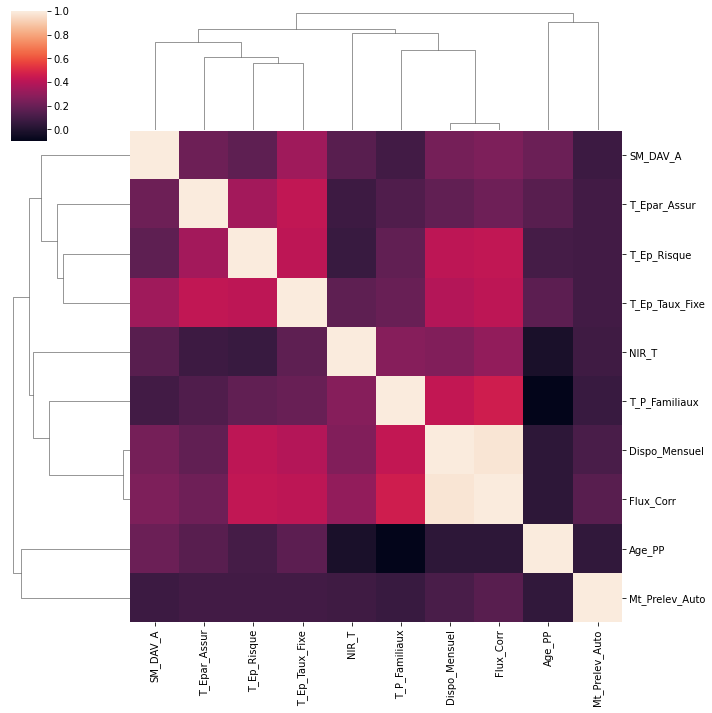

In [14]:
# Analyse des corrélations
sns.clustermap(df_ind.select_dtypes("int64").corr())

In [15]:
# Création de deux variables : l'une contenant les individus n'ayant pas de prêt automobile et une seconde contenant 
# les individus ayant un prêt automobile
df_oui = df_ind[df_ind["P_P_Auto"]==1]
df_non = df_ind[df_ind["P_P_Auto"]==0]

# Obtenir les proportion par modalité
print("Il y a", round(df_ind["P_P_Auto"].value_counts(normalize=True)[0]*100, 1), "% de clients qui ont déjà un prêt automobile et", round(df_ind["P_P_Auto"].value_counts(normalize=True)[1]*100, 1), "% n'en ont pas.")

Il y a 84.3 % de clients qui ont déjà un prêt automobile et 15.7 % n'en ont pas.


<AxesSubplot:xlabel='P_P_Auto', ylabel='count'>

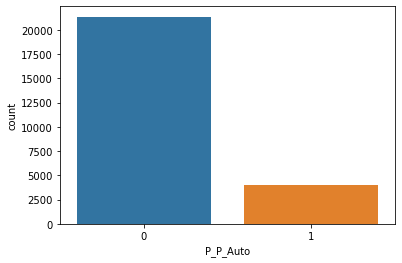

In [16]:
## Graphiquement
sns.countplot(x="P_P_Auto",data=df_ind)

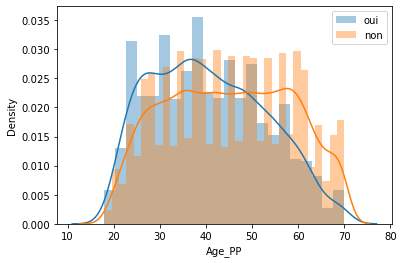

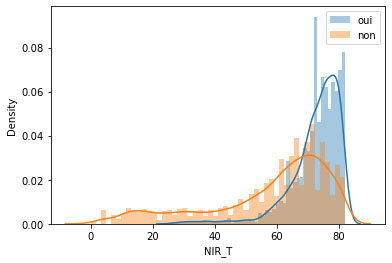

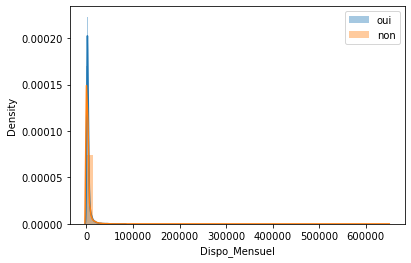

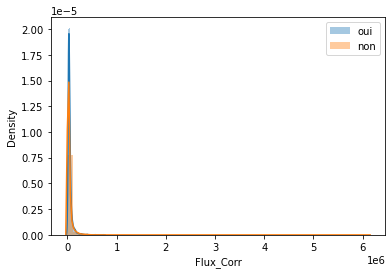

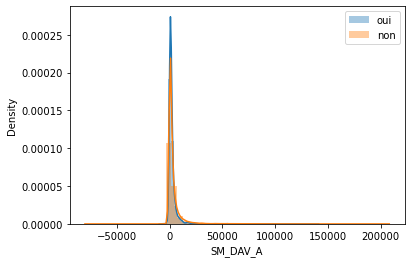

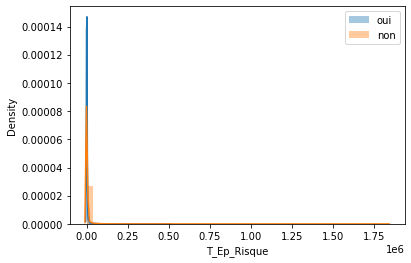

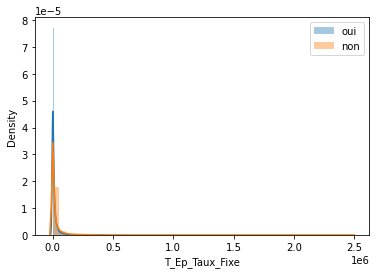

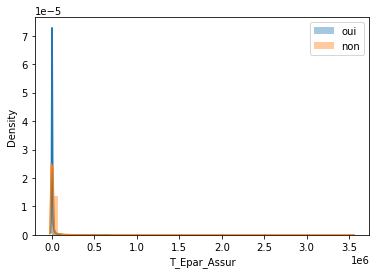

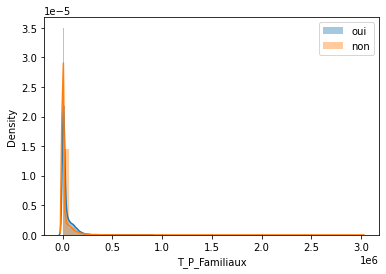

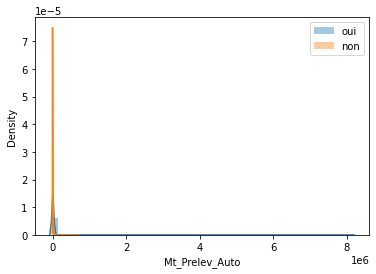

In [17]:
# Courbes de distribution des variables quantitatives
for col in df_ind.select_dtypes('int64'):
    plt.figure()
    sns.distplot(df_oui[col], label="oui")
    sns.distplot(df_non[col], label="non")
    plt.legend()

In [18]:
#taille des échantillons
print(df_oui.shape)
print(df_non.shape)

(3973, 14)
(21351, 14)


In [19]:
# Création d'un échantillon équivalent équilibré
df_non_test = df_non.sample(3973)


# test de student
def ttest(col):
    alpha = 0.05
    stat, p = ttest_ind(df_non_test[col], df_oui[col])
    if p < alpha:
        return "H0 rejetée"
    else:
        return "H0 acceptée"

for col in df_ind.select_dtypes("int64"):
    print(f'{col:-<50} {ttest(col)}') 

Age_PP-------------------------------------------- H0 rejetée
NIR_T--------------------------------------------- H0 rejetée
Dispo_Mensuel------------------------------------- H0 rejetée
Flux_Corr----------------------------------------- H0 rejetée
SM_DAV_A------------------------------------------ H0 rejetée
T_Ep_Risque--------------------------------------- H0 rejetée
T_Ep_Taux_Fixe------------------------------------ H0 rejetée
T_Epar_Assur-------------------------------------- H0 rejetée
T_P_Familiaux------------------------------------- H0 rejetée
Mt_Prelev_Auto------------------------------------ H0 acceptée


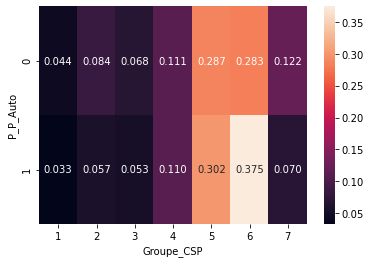

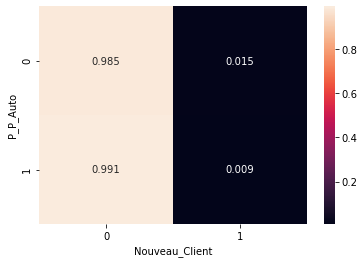

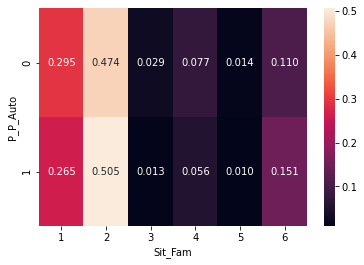

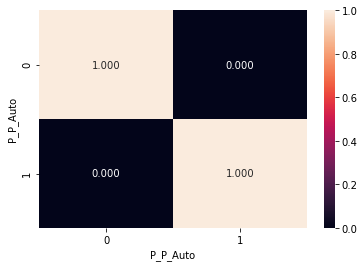

In [20]:
# Proportion des variables catégorielles en fonction de la variable cible.
for col in df_ind.select_dtypes('category'):
    plt.figure()
    sns.heatmap(pd.crosstab(df_ind["P_P_Auto"], df_ind[col],normalize='index'), annot=True, fmt='.3f')

## Modélisation <a class="anchor" id="modelisation"></a> 

Dans cette partie, l'objectif est de trouver le meilleur modèle possible pour déterminer la varibale **P_P_Auto**.

In [21]:
# Création des variables x et y
x = df_ind.drop("P_P_Auto",axis=1)
y = df_ind["P_P_Auto"]

# Création des variables train et test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=100, stratify = y)

### Régression logistique <a class="anchor" id="RegLog"></a> 

La première méthode de modélisation utilisée est la régression logistique.

On constate que le taux de bonne classification du modèle par régression logitistique est égal à 84.2%. Dans 84.3% des cas, le classifieur donne la valeur 0 quand la valeur réelle est 0 et dans 36.3% des cas, il donne la valeur 1 quand la valeur réelle est 1 (précision). Dans 99.8% des cas, le classifieur donne la bonne valeur de 0. A contrario, le classifieur donne la bonne valeur de 1 dans 0.05%. Le modèle n'est pas robuste puisqu'il se trompe beaucoup sur 1 (recall).

In [38]:
# Régression logistique
lr = LogisticRegression(random_state=1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
print(lr.score(x_test, y_test))
print(classification_report(y_test, y_pred, digits=4))
pd.crosstab(y_test, y_pred)

0.8424481737413623
              precision    recall  f1-score   support

           0     0.8435    0.9984    0.9144      4270
           1     0.3636    0.0050    0.0099       795

    accuracy                         0.8424      5065
   macro avg     0.6036    0.5017    0.4622      5065
weighted avg     0.7682    0.8424    0.7724      5065



col_0,0,1
P_P_Auto,,
0,4263,7
1,791,4


#### Régression logistique équilibrée  <a class="anchor" id="RegLogEqui"></a> 

On constate que le taux de bonne classification du modèle par régression logitistique est égal à 58.53%. Ce modèle est donc moins robuste que le modèle de régression logistique non équilibrée. Toutefois, on constate qu'il est plus robuste pour détecter les vrais négatifs mais perd en précision pour détecter les vais positifs. En effet, dans 94.3% des cas, le classifieur donne la valeur 0 quand la valeur réelle est 0 et dans 25.05% des cas il donne la valeur 1 quand la valeur réelle est 1 (précision). Dans 54.10% des cas, le classifieur donne la bonne valeur de 0. A contrario, le classifieur donne la bonne valeur de 1 dans 82.39% (recall).

In [24]:
## Régression équilibrée
lrEquilibree = LogisticRegression(random_state=1, class_weight='balanced')
lrEquilibree.fit(x_train,y_train)
y_pred_EquiRg = lrEquilibree.predict(x_test)
print(lrEquilibree.score(x_test, y_test))

print(classification_report(y_test, y_pred_EquiRg, digits=4))
pd.crosstab(y_test, y_pred_EquiRg)

0.5853899308983218
              precision    recall  f1-score   support

           0     0.9429    0.5410    0.6875      4270
           1     0.2505    0.8239    0.3842       795

    accuracy                         0.5854      5065
   macro avg     0.5967    0.6824    0.5358      5065
weighted avg     0.8342    0.5854    0.6399      5065



col_0,0,1
P_P_Auto,,
0,2310,1960
1,140,655


#### Régression logistique sur échantillon manuellement équilibré <a class="anchor" id="RegLogEquiMan"></a> 

Pour obtenir exactement la même répartition entre ceux qui ont un crédit en cours et ceux qui n'en ont pas, nous faisons un tirage aléatoire de 3973 individus parmi ceux qui n'ont pas de crédit en cours. Ce chiffre représente le total des individus qui ont un crédit en cours. Ainsi, une nouvelle base de données est créée. Cette dernière est composée de 7846 clients dont 50% ont un crédit automobile en cours et l'autre moitié n'en a pas. Cela a pour objetcif d'améliorer la précision de notre modèle sur la selection des clients qui ont un prêt automobile.

In [30]:
# Echantillon equilibré à la main
df_ind_0 = df_ind[df_ind["P_P_Auto"]==0].sample(n=3973, replace=False)
df_ind_equi = pd.concat([df_ind_0, df_ind[df_ind["P_P_Auto"]==1]])

# Vérification que l'échantillon est équilibré
df_ind_equi["P_P_Auto"].value_counts()

1    3973
0    3973
Name: P_P_Auto, dtype: int64

In [31]:
# Création de nouvelles variables d'entrainement et de test x2 et y2
x2 = df_ind_equi.drop("P_P_Auto", axis=1)
y2 = df_ind_equi['P_P_Auto']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=1)

# Nouvelle régression logistiques avec les nouvelles variables
lrEqMan = LogisticRegression()
lrEqMan.fit(x2_train, y2_train)
y2_pred = lrEqMan.predict(x2_test)
print(lrEqMan.score(x2_test, y2_test))

print(classification_report(y2_test, y2_pred, digits=4))
pd.crosstab(y2_test, y2_pred)

0.6735849056603773
              precision    recall  f1-score   support

           0     0.7491    0.5096    0.6065       785
           1     0.6354    0.8335    0.7211       805

    accuracy                         0.6736      1590
   macro avg     0.6922    0.6715    0.6638      1590
weighted avg     0.6915    0.6736    0.6645      1590



col_0,0,1
P_P_Auto,,
0,400,385
1,134,671


La perfomance de ce modèle est mieux que celle de la régréssion logistique équilibrée. En effet, malgré une perte de précision sur la détection des vrais positifs (74.91% contre 94.29% avec le modèle précédent), ce modèle s'avère avoir une meilleure détection des vrais négatifs (63.54% contre 25.05% avec le modèle précédent).

#### Régréssion logistique par validation croisée <a class="anchor" id="RegLogVa"></a> 

Par validation croisée, la capacité de la régression logistique à détecter les vrais négatifs est de 26.08% (précision) avec une performance globale de 83.9%.

In [25]:
#k-fold
lr = LogisticRegression(random_state=1)

print('Precision :', cross_val_score(lr, x, y, cv=5, scoring='precision').mean())
print('Recall :', cross_val_score(lr, x, y, cv=5, scoring='recall').mean())
print('accuracy :', cross_val_score(lr, x, y, cv=5, scoring='accuracy').mean())

Precision : 0.26808833678398897
Recall : 0.012842545506392283
accuracy : 0.8390456451595295


### Random Forest <a class="anchor" id="RandomForest"></a> 

La seconde méthode utilisée est le Random Forest. Entraîné sur 100 arbres, la performance du modèle est de 86.77%. Cependant, il a une meilleure précision sur la capacité à détecter les vrais positifis (88.54%) et les vrais négatifs (65.82%).   

In [43]:
## Random forest
rf = RandomForestClassifier(n_jobs=-1, random_state=1)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(rf.score(x_test, y_test))
print(classification_report(y_test, y_pred_rf, digits=4))
pd.crosstab(y_test, y_pred_rf)

0.8677196446199408
              precision    recall  f1-score   support

           0     0.8854    0.9684    0.9251      4270
           1     0.6582    0.3270    0.4370       795

    accuracy                         0.8677      5065
   macro avg     0.7718    0.6477    0.6810      5065
weighted avg     0.8498    0.8677    0.8484      5065



col_0,0,1
P_P_Auto,,
0,4135,135
1,535,260


#### Random Forest sur écahntillon manuellement équilibré <a class="anchor" id="RandomForestEqMan"></a> 

Entraîné par défaut sur 100 arbres avec une profondeur de 2 (choisi sur la courbe d'apprentissage), la performance du modèle est de 93.39%. Il a une meilleure précision sur la capacité à détecter les vrais positifis (93.49%) et les vrais négatifs (74.16%). 

In [32]:
## Random forest
rfEqMan = RandomForestClassifier(n_jobs=-1, random_state = 1, max_depth=2)
rfEqMan.fit(x2_train, y2_train)
y_pred_rfEq = rfEqMan.predict(x2_test)
print(rf.score(x2_test, y2_test))
print(classification_report(y2_test, y_pred_rfEq, digits=4))
pd.crosstab(y2_test, y_pred_rfEq)

0.9339622641509434
              precision    recall  f1-score   support

           0     0.9349    0.6586    0.7728       785
           1     0.7416    0.9553    0.8350       805

    accuracy                         0.8088      1590
   macro avg     0.8382    0.8069    0.8039      1590
weighted avg     0.8370    0.8088    0.8043      1590



col_0,0,1
P_P_Auto,,
0,517,268
1,36,769


#### Selection des hyperparamètres en Random Forest <a class="anchor" id="RanForSelectPara"></a> 

Il est possible de déterminer les hyperparamètres qui améliorent les performances du random Forest (très long).  Pour être optimale , il faudrait élargir les champs des paramètres à choisir. 

In [82]:
# Configuration des hyper paramètres
param_grid={'n_estimators':[100, 200, 300],
           'max_depth':np.arange(2, 100, 10)}


In [83]:
# Test les différents paramètres
grid=GridSearchCV(RandomForestClassifier(),param_grid,cv = 10)

# Entraîne le modèle
grid.fit(x_train, y_train)

# Affiche le meilleur modèle
print(grid.best_score_)
print(grid.best_params_)

# Entraîne avec les meilleurs paramètres
modelBestPara = grid.best_estimator_
print(modelBestPara.score(x_test, y_test))

0.8618888279526647
{'max_depth': 52, 'n_estimators': 200}
0.8614017769002962


#### Importance des variables par Random Forest <a class="anchor" id="ImpVariable"></a> 

In [27]:
# # Selection des variables qui contribuent le plus
v = rf.feature_importances_

#Affiche les variables et leurs contributions dans un data frame 
importance_var_rf = pd.DataFrame({"variables":df_ind.columns.drop("P_P_Auto"), "Importance":v*100})
importance_var_rf.sort_values(by = 'Importance', ascending = False)

,variables,Importance
11,T_P_Familiaux,25.681393
4,NIR_T,10.084225
6,Flux_Corr,9.333073
7,SM_DAV_A,9.162281
12,Mt_Prelev_Auto,8.977873
9,T_Ep_Taux_Fixe,8.763913
5,Dispo_Mensuel,8.527445
1,Age_PP,7.649213
10,T_Epar_Assur,3.977203
0,Groupe_CSP,3.007096


Suivant le Random Forest, les variables qui contribuent le plus à l'octroi ou non d'un prêt automobile sont la somme des crédits en cours (T_P_Familiaux), l'intensité de relation avec la banque NIR_T), les flux créditeurs corrigés de l'année en cours (Flux_Corr), la capacité à épargner à taux fixe. Cependant, le fait d'être un nouveau client n'est pas déterminant dans l'octroi d'un prêt.  

### SVM <a class="anchor" id="SVM"></a> 

Le SVM entrainé avec un noyau radial (par défaut 'rbf') donne une performance de 84.28%. Il a une précision de 84.30 % sur la capacité à détecter les vrais positifs. Cependant, il a une précision nulle sur les vrais négatifs.

In [34]:
#SVM
svm = SVC(probability=True, random_state = 1)
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

print(svm.score(x_test, y_test))
print(classification_report(y_test, y_pred_svm, digits=4))

pd.crosstab(y_test, y_pred_svm)

0.8428430404738401
              precision    recall  f1-score   support

           0     0.8430    0.9998    0.9147      4270
           1     0.0000    0.0000    0.0000       795

    accuracy                         0.8428      5065
   macro avg     0.4215    0.4999    0.4574      5065
weighted avg     0.7107    0.8428    0.7711      5065



col_0,0,1
P_P_Auto,,
0,4269,1
1,795,0


#### SVM sur échantillon manuellement équilibrée <a class="anchor" id="SvmManuel"></a> 

Le SVM entrainé avec un noyau radial donne une performance de 70.62%. Il a une précision de 72.52 % sur la capacité à détecter les vrais positifs. Cependant, les précisions sur les vrais négatifs sont largement meilleurs que le modèle précédent.

In [33]:
#SVM
svmMan = SVC(probability = True, random_state = 1)
svmMan.fit(x2_train, y2_train)
y2_pred_svm = svmMan.predict(x2_test)

print(svmMan.score(x2_test, y2_test))

print(classification_report(y2_test, y2_pred_svm , digits=4))
pd.crosstab(y2_test, y2_pred_svm)

0.7062893081761006
              precision    recall  f1-score   support

           0     0.7252    0.6522    0.6868       785
           1     0.6912    0.7590    0.7235       805

    accuracy                         0.7063      1590
   macro avg     0.7082    0.7056    0.7051      1590
weighted avg     0.7080    0.7063    0.7054      1590



col_0,0,1
P_P_Auto,,
0,512,273
1,194,611


#### Selection des hyperparamètres en SVM <a class="anchor" id="SvmSelectPara"></a>

Il est possible de déterminer les hyperparamètres qui améliorent les performances du SVM. Cependant, nous n'avons pas  réussi à obtenir les sorties car très long.  (Nous avons attentu 1 heure sans sortie).

In [33]:
# Configuration des hyper paramètres
param_grid = [
  {'C': [1, 10, 50], 'kernel': ['linear']},
  {'C': [1, 10, 50], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [ ]:
# Test les différents paramètres
grid=GridSearchCV(SVC(),param_grid,cv = 10)

# Entraîne le modèle
grid.fit(x_train, y_train)

# Affiche le meilleur modèle
print(grid.best_score_)
print(grid.best_params_)

# Entraîne avec les meilleurs paramètres
modelBestPara = grid.best_estimator_
print(modelBestPara.score(x_test, y_test))

### Bagging  & Boosting  <a class="anchor" id="Bagging"></a>

Ensuite, nous avons utilisé le bagging et le boosting. Le modèle de Bagging est légèrement moins performant que le boosting (85.31% contre 86.23%). Le modèle de boosting a une meilleure précision sur la capacité à détecter les vrais négatifs. Et inversement, le modèle de boosting a une meilleure précision sur la capacité à détecter les vrais positifs. 

In [35]:
# Bagging 
model_bagging = BaggingClassifier(base_estimator= ExtraTreesClassifier(), n_estimators=100, random_state = 1)
model_bagging.fit(x_train, y_train)
y_pred_bag = model_bagging.predict(x_test)
print(model_bagging.score(x_test, y_test))
print(classification_report(y_test, y_pred_bag, digits=4))
pd.crosstab(y_test, y_pred_bag)

0.8531095755182626
              precision    recall  f1-score   support

           0     0.8626    0.9822    0.9185      4270
           1     0.6256    0.1597    0.2545       795

    accuracy                         0.8531      5065
   macro avg     0.7441    0.5710    0.5865      5065
weighted avg     0.8254    0.8531    0.8143      5065



col_0,0,1
P_P_Auto,,
0,4194,76
1,668,127


In [28]:
## boosting
model_boost = AdaBoostClassifier(n_estimators = 100, random_state = 1)
model_boost.fit(x_train, y_train)
y_pred_boost = model_boost.predict(x_test)
print(model_boost.score(x_test, y_test))
print(classification_report(y_test, y_pred_boost, digits=4))
pd.crosstab(y_test,y_pred_boost)

0.8623889437314907
              precision    recall  f1-score   support

           0     0.8888    0.9564    0.9214      4270
           1     0.6043    0.3572    0.4490       795

    accuracy                         0.8624      5065
   macro avg     0.7465    0.6568    0.6852      5065
weighted avg     0.8441    0.8624    0.8472      5065



col_0,0,1
P_P_Auto,,
0,4084,186
1,511,284


### Vérification de l'overfitting  <a class="anchor" id="VerifOverfitting"></a>

Nous vérifions l'écart entre les performances du modèle sur le **train set** et la **test set** en fonction du paramètre max_depth afin de détecter l'overfitting. Ainsi, au délà de max_depth=5, l'écart se dessine entre les performances du train set et du test set. En effet, la perforamnce sur le train set repart à la hausse tandis que celle du test set augmente mais moins rapidement.

#### Courbe de validation

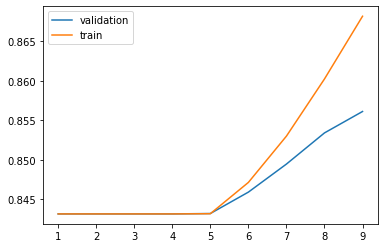

In [41]:
## Validation curve
model = RandomForestClassifier()
k = np.arange(1, 10)
train_score, val_score = validation_curve(model, x_train, y_train,'max_depth', k, cv=10)

plt.plot(k, val_score.mean(axis = 1), label = "validation")
plt.plot(k, train_score.mean(axis = 1), label= "train")
plt.legend()

### Choix du modèle optimal : courbe ROC <a class="anchor" id="CourbeRoc"></a> 

On évalue l'aire sous la courbe des différents modèles étudiés jusqu'ici.

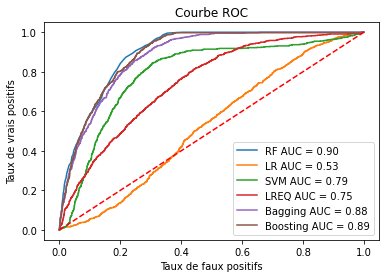

In [39]:
#Courbe ROC
modeles = ['RF', 'LR', 'SVM', 'LREQ','Bagging', 'Boosting']

plt.title('Courbe ROC')

for i, model in enumerate([rf, lr, svm, lrEquilibree, model_bagging, model_boost]):
    probs = model.predict_proba(x_test) 
    preds = probs[:,1] 
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    tpr = np.insert(tpr, 0, 0)
    fpr = np.insert(fpr, 0, 0)

    plt.plot(fpr, tpr, label = modeles[i]+' AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

#### Courbe ROC (manuel)

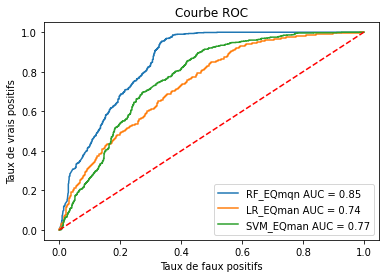

In [40]:
# Courbes ROC
modeles = ['RF_EQmqn', 'LR_EQman', 'SVM_EQman']

plt.title('Courbe ROC')

# modelBestPara, modelBestParaSvm, 
for i, model in enumerate([rfEqMan, lrEqMan, svmMan]):
    probs = model.predict_proba(x2_test) 
    preds = probs[:,1] 
    fpr, tpr, threshold = roc_curve(y2_test, preds)
    roc_auc = auc(fpr, tpr)

    tpr = np.insert(tpr, 0, 0)
    fpr = np.insert(fpr, 0, 0)

    plt.plot(fpr, tpr, label = modeles[i]+' AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

Les Random Forest (sur échantillon équilibré manuellement ou non), le Boosting et le Bagging sont les modèles les plus performants avec respectivement des AUC de 0.85, 0.9, 0.89 et 0.88. Nous avons donc choisit comme modèle le Radom Forest.

## Selection des clients les plus appétents  <a class="anchor" id="SelecClients"></a> 

In [44]:
# Création d'une copie de df_ind en conservant les index
ClientsAp = df_ind.copy(deep=True)


ClientsAp = ClientsAp[ClientsAp["P_P_Auto"]==0]
x_ClientsAp = ClientsAp.drop("P_P_Auto",axis=1)
y_ClientsAp = ClientsAp["P_P_Auto"]

In [45]:
# On réaliser une prédiction via la modèle de Random Forest sur échantillon manuellement équilibré
y_pred_ClientsAp = rf.predict(x_ClientsAp)
print(rf.score(x_ClientsAp, y_ClientsAp))
print(classification_report(y_ClientsAp, y_ClientsAp, digits=4))
pd.crosstab(y_ClientsAp, y_pred_ClientsAp)

0.9936771111423353
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     21351

    accuracy                         1.0000     21351
   macro avg     1.0000    1.0000    1.0000     21351
weighted avg     1.0000    1.0000    1.0000     21351



col_0,0,1
P_P_Auto,,
0,21216,135


In [46]:
# Probabilité de la prédiction 
new = rf.predict_proba(x_ClientsAp)
new

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [47]:
# Extraction des probabilité d'appartenence à 1
ClientsAp["prob"] = new[:,1]

# Ordonne les probabilités par ordre décroissant
ClientsAp_sort = ClientsAp.sort_values(by="prob", ascending=False)

# Affichage des 5000 premières clients 
print("Voici la liste des 5000 personnes les plus appétentes à l'offre de prêt automobile.")
ClientsAp_sort.head(5000)

Voici la liste des 5000 personnes les plus appétentes à l'offre de prêt automobile.


,Groupe_CSP,Age_PP,Nouveau_Client,Sit_Fam,NIR_T,Dispo_Mensuel,Flux_Corr,SM_DAV_A,T_Ep_Risque,T_Ep_Taux_Fixe,T_Epar_Assur,T_P_Familiaux,Mt_Prelev_Auto,P_P_Auto,prob
Numero_Client,,,,,,,,,,,,,,,
37080,6,20,0,1,70,1603,21918,151,0,555,0,4238,1764,0,0.83
5541,6,26,0,1,69,1693,27145,1072,0,1134,0,4519,4846,0,0.81
33999,6,21,0,1,71,1810,29386,597,210,1537,0,7824,4900,0,0.80
25352,6,52,0,2,81,3213,34093,1978,0,2748,0,10968,5612,0,0.79
23212,4,29,0,2,70,3462,35096,1249,0,922,0,5389,885,0,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28380,6,55,0,2,72,2524,28255,1009,0,24463,0,6947,6265,0,0.10
24714,6,30,0,2,80,1913,29965,1556,0,3046,0,136650,6103,0,0.10
23026,1,44,0,2,81,2386,37780,-22,429,1152,2237,86920,6520,0,0.10
